In [41]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install tensorflow torch torchvision torchaudio

In [97]:
import kagglehub
import os                                                ##  Modul os je součástí standardní knihovny Pythonu a umožňuje pracovat se soubory a adresáři v operačním systému. 
                                                         ##  Často se používá ke čtení/zápisu souborů, získání cest k souborům a manipulaci s adresáři. 

from PIL import Image                                    ## PIL (Python Imaging Library, dnes známá jako Pillow) je knihovna pro manipulaci s obrázky. 
                                                         ## Image umožňuje otevírat, upravovat a ukládat obrázky ve formátech jako PNG, JPEG, BMP atd. 

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split     ## Rozdělení datasetu na trénovací a testovací část
from keras.utils import to_categorical                   ##  Konverze štítků do One-Hot Encoding, Místo číselného označení jako 0, 1, 2, 
                                                         ##  což by mohlo způsobit chyby v učení (síť by mohla mylně považovat 2 za „větší“ než 1), použijeme One-Hot Encoding:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from keras.applications import MobileNetV3Large     ## je předtrénovaný model hlubokého učení určený pro rozpoznávání obrazu.
                                                    ## Model je předtrénován na obrovském datasetu ImageNet a lze jej dále upravit (tzv. transfer learning).
from keras.layers import GlobalAveragePooling2D     ## redukuje dimenzionalitu výstupních dat.
from keras.models import Model                      ## Model umožňuje sestavit vlastní architekturu neuronové sítě v Kerasu.
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.regularizers import l2
from keras.utils import to_categorical

In [44]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

## Načtení a preprocessing dat

In [82]:
path = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE"

In [83]:
fotky_emoce = os.listdir(f"{path}/train_OK")

In [84]:
# Načtení fotek a přiřazení názvů emocí ( labling)
X = []     
y = []     
encoding = {}   

for index, emoce in enumerate(fotky_emoce):        
  encoding[index] = emoce
  folder_path = os.path.join(f"{path}/train_OK", emoce)

  # Vytvoření datasetu
  image_list = []     
  for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):    
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img_resized = img.resize((48, 48))   # změna velikosto obrázku   
        img_array = np.array(img_resized)    # převod na numpy array
        image_list.append(img_array)         # rozšíření seznamu obrázků

  X += image_list    #   Přidáme všechny obrázky z této složky do seznamu X.
  y += [index] * len(image_list)  ## přiřazení čísel k labelům 

In [85]:
X = np.stack(X)
y = np.array(y)
X = X / 255  # Normalizování obrázků

In [86]:
# rozdělení, trénink test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# one hot encoding y 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [87]:
# Zastavení trénování modelu, pokud nejsou změny větší než 0,3%
early = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.003,
    patience=10,
    restore_best_weights=True,
)
# Uložení nejlepšího modelu
save = ModelCheckpoint(
    filepath="best_model_nase_neuronova_sit.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch"
)

## Trénování modelu našeho modelu neuronové sítě

In [52]:
model = Sequential()
model.add(Input(shape=(48, 48, 1)))
# První konulenční vrstva neuronové sitě
model.add(Conv2D(32, (3, 3),input_shape=(48, 48, 1)))
model.add(MaxPooling2D())
# Druhá konulenční vrstva neuronové sitě
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D())
# Třetí konulenční vrstva neuronové sitě
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D())
model.add(Flatten())   # převést na vektor
model.add(Dropout(0.5))  # regularizace proti overfittingu
# Klasifikační vrstva
model.add(Dense(128, activation='relu'))   ## kernel_regularizer=l2(0.001)

# výstupní vrstva -> multiclass single label -> softmax
model.add(Dense(len(fotky_emoce), activation="softmax"))

# kompilace
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\zitao\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,167 (625.65 KB)

 Trainable params: 160,167 (625.65 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
## Total params:   Celkový počet parametrů ve vašem modelu, které jsou trénovatelné i netrénovatelné dohromady.
## Trainable params:  Počet parametrů, které se mění během trénování – model se učí jejich optimální hodnoty.

In [54]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3901 - loss: 1.6427 - val_accuracy: 0.5790 - val_loss: 1.1892
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5903 - loss: 1.1638 - val_accuracy: 0.6396 - val_loss: 1.0360
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6322 - loss: 1.0340 - val_accuracy: 0.6679 - val_loss: 0.9318
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6770 - loss: 0.9146 - val_accuracy: 0.6928 - val_loss: 0.8683
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7077 - loss: 0.8255 - val_accuracy: 0.7032 - val_loss: 0.8299
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7347 - loss: 0.7617 - val_accuracy: 0.7047 - val_loss: 0.8092
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7414 - loss: 0.7315 - val_accuracy: 0.7300 - val_loss: 0.7656
Epoch 8/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7651 - loss: 0.6508 -

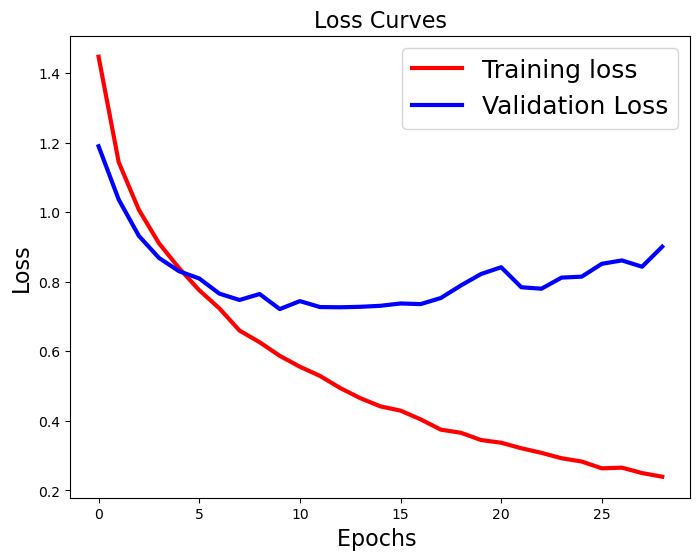

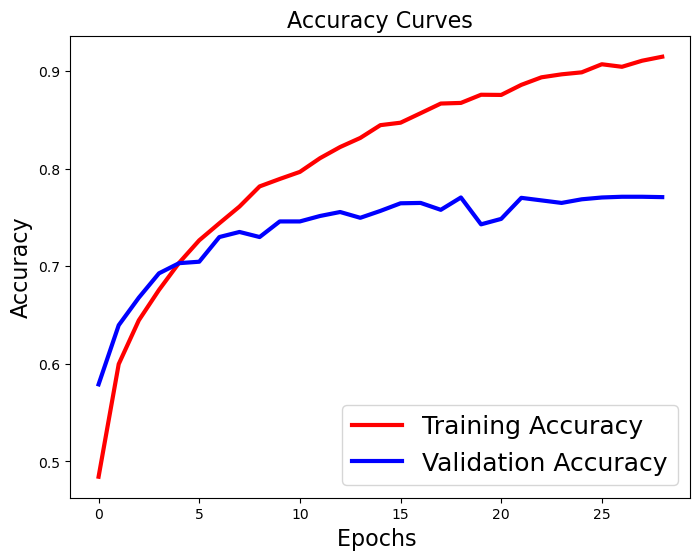

In [55]:
plot_history(history)

In [88]:
model = load_model("best_model_nase_neuronova_sit.keras")

In [89]:
y_pred = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [90]:
y_pred = np.argmax(y_pred, axis=1)

In [91]:
y_test = np.argmax(y_test, axis=1)

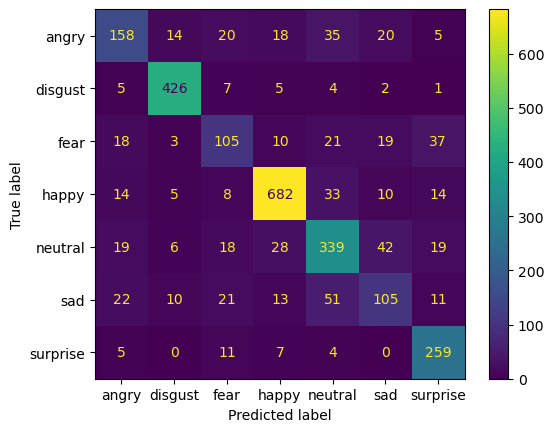

In [99]:
## plt.title("Confusion Matrix  - Vlastní neuronka")  # Název grafu


class_labels = list(encoding.values())
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()